In [1]:
import numpy as np     
import pandas as pd              
import matplotlib.pyplot as plt
from matplotlib import cm
import math


# Clases propias
from SignalClases import OrgSignal
from SignalClases import FiltSignal
from SignalClases import SWSignal
from SignalClases import IndSW
from SignalClases import saveData
from ImgPlot import Plot_Signals
from Hilbert import HilbClass
from CrossDetClass import crossDetector
from timeDetClass import tDetClass
from recSigClass import recClass
from saveList import save

In [2]:
##  Cargar una muestra para prueba
foldNum = 0             # CBX
fileNum = 5             # FR - 94
srate = 10000           # tasa de muestreo 

In [3]:
### ****** Carga de señales ******
## Señal Original 
orgSignal, path, file = OrgSignal.getData(foldNum,fileNum)    # Señal original 
# print(path)               # ruta de la carpeta 
# print(file)               # num. de archivo
# print(orgSignal.shape)      # dimension del arreglo     

## Señal Filtrada   250 - 550 Hz
filtSig,filtPath = FiltSignal.getData(foldNum,fileNum)           # Señal Filtrada
print(filtPath)
print(filtSig.shape)

## Señal Slow Wave 
SWSig = SWSignal.getData(foldNum,fileNum)               # Señal filtrada para detección de ondas lentas 
print(SWSig.shape)

## Indice de SW
label = 0
indSW,labelInd = IndSW.getData(foldNum,fileNum,label)   # Fragmentos de indices de SWR 
indSize = indSW.shape
print(indSize)
print(indSW[0,0])        # primeros indices de swr detectados [fila, columna]
print(indSW[0,1])



S:\\Proyecto Epilepsia\\Base de datos proyecto sin repeticion\\experimental CBX proyecto\\FR-94_CBX_n.mat
S:\\Proyecto Epilepsia\\Base de datos filtrada\\CBX_f\\FR-94_CBX_f\\FR-94_CBX_f.mat
S:\\Proyecto Epilepsia\\Base de datos filtrada\\CBX_f\\FR-94_CBX_f\\FR-94_CBX_f.mat
(8, 17620001)
S:\\Proyecto Epilepsia\\Slow Wave Filter\\experimental CBX proyecto\\FR-94_CBX_SWF\\FR-94_CBX_SWF.mat
(8, 17620001)
S:\\Proyecto Epilepsia\\Slow Wave Index\\experimental CBX proyecto\\FR-94_CBX_ind\\HAD1\\FR-94_CBX_ind_HAD1.mat
(148, 2)
81862
104861


In [4]:
## Datos extras de la señal 
szOrg = orgSignal.shape
timevec = np.arange(0,szOrg[1],1)/srate  ## Vector de tiempo
print(timevec.shape)

(17620001,)


Text(0.06, 0.5, 'Amplitude (V)')

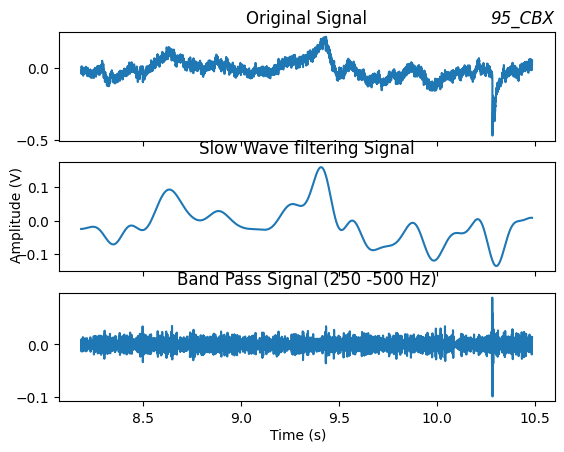

In [5]:
### Plot de las señales  (Original, filtrada SW, filtrada FR)
numInd = 0   ## No. de SW 

# Grafica señal original
fig, axs = plt.subplots(3, sharex=True)
axs[0].plot(timevec[indSW[numInd,0]:indSW[numInd,1]],orgSignal[label,indSW[numInd,0]:indSW[numInd,1]])    # Señal Orginal
axs[0].set_title('Original Signal')
axs[0].set_title('95_CBX', loc='right', style = "italic")
axs[1].plot(timevec[indSW[numInd,0]:indSW[numInd,1]],SWSig[label,indSW[numInd,0]:indSW[numInd,1]])  # Senal Slow Wave
axs[1].set_title('Slow Wave filtering Signal')
axs[2].plot(timevec[indSW[numInd,0]:indSW[numInd,1]],filtSig[label,indSW[numInd,0]:indSW[numInd,1]]*.001)   # Señal band pass 250-500 Hz
axs[2].set_title('Band Pass Signal (250 -500 Hz)')
fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center')
fig.text(0.06, 0.5, 'Amplitude (V)', ha='center', va='center', rotation='vertical')

Determinar envoltura de hilbert, thold, y medthold

In [6]:
prubeSignal = (filtSig[label,indSW[numInd,0]:indSW[numInd,1]]*.001).copy() # copiar la información de la señal 
ampEnv, thold,medT = HilbClass.HBSig(prubeSignal)  # Indicar treshold y midthreshold
t = timevec[indSW[numInd,0]:indSW[numInd,1]]

(8.49, 8.51)

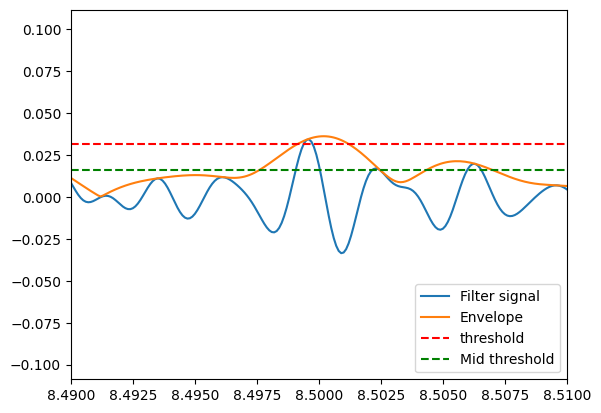

In [7]:
## Plot  Fig filtrada, envoltura y thold 
fig = plt.figure()
axs = fig.add_subplot(1,1,1)
axs.plot(t, prubeSignal, label = 'Filter signal')
axs.plot(t,ampEnv, label = 'Envelope')
axs.axhline(y = thold, color='r',linestyle='--', label='threshold')
axs.axhline(y = medT, color='g',linestyle='--', label='Mid threshold')
plt.legend(loc='lower right')
axs.set_xlim([8.49,8.51])

### Determinación de cruces thold

In [8]:
## Extracción de umbral de la señal filtrada y de la envoltura
sigWT = prubeSignal - thold     # Extracción de umbral de la señal original 
envWM = ampEnv-thold            # Extracción de umbral de la envoltura 


(8.49, 8.51)

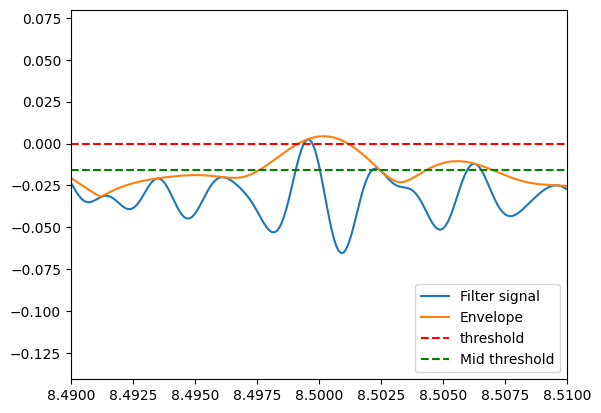

In [9]:
## Plot 
# Grafica señal original
fig = plt.figure()
axs = fig.add_subplot(1,1,1)
axs.plot(t, sigWT, label = 'Filter signal')     # Señal con la extracción del threshold
axs.plot(t,envWM, label = 'Envelope')           # Envoltura menos el thold 
axs.axhline(y = 0, color='r',linestyle='--', label='threshold')         # thold pasa a ser 0
axs.axhline(y = medT-thold, color='g',linestyle='--', label='Mid threshold')    # medT-thold 
plt.legend(loc='lower right')
axs.set_xlim([8.49,8.51])


In [19]:
## Detectar cruces por cero 
def zeroCrossing(signal):
    crossing = np.where(np.diff(np.sign(signal)))[0] 
    
    sgnCross = (np.sign(signal[crossing])).astype(int)
    # np.sign(signal) #-1 -> valor negativo, 0-> valor exactamente 0, 1 -> valor positivo
    # np.diff(np.sign(signal)) -> calcula la diferencia de elementos consecutivos (n)-(n-1) elemento actual - elemento anterior [1,2,3,4] [2]-[1]
    # np.where indices de posiciones donde pasa el cambio [0] toma el valor del arreglo en la posción 0, esta tomando los valores del array distintos de 0
    # se esta guardando el punto anterior al cruce con sus respectivo signo por tanto para saber si sube o baja debemos tomar n+1
    return crossing,sgnCross

def ppCross(crossing,sgnCross):
    pre = []
    post = []

    for i in range(crossing.size-1):
        if ((sgnCross[i]== -1) and (sgnCross[i+1]== 1)):
            pre.append(crossing[i])
            post.append(crossing[i+1]+1)   # +1 ya que el signo +1 que se guarda es el signo anterior al cruce (1 1 -1 -1) -> en este caso se guarda el 1 para así cerrar la onda en el siguiente instante de muestreo 

    pre = np.array(pre)
    post = np.array(post)
    return pre, post

In [17]:
crossDet,sngCross = zeroCrossing(envWM)
print(crossDet)
print(sngCross)

[ 3129  3149  4628  4645 12472 12497 18549 18570 20952 21004 21015 21032]
[-1  1 -1  1 -1  1 -1  1 -1  1 -1  1]


In [20]:
pre,post = ppCross(crossDet, sngCross)
print(pre)
print(post)

[ 3129  4628 12472 18549 20952 21015]
[ 3150  4646 12498 18571 21005 21033]


(10.03, 10.05)

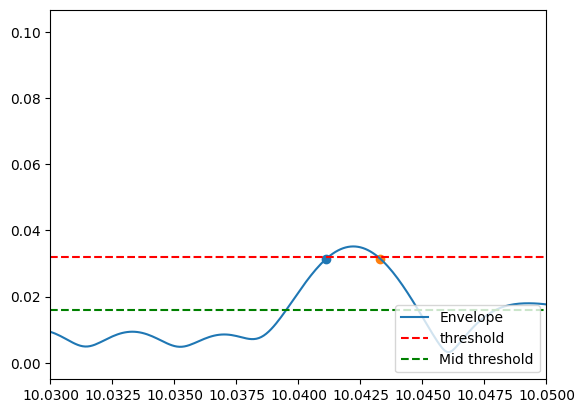

In [49]:
## Plot grafica filtrada y thold originales
fig = plt.figure()
axs = fig.add_subplot(1,1,1)
# axs.plot(t, sigWT, label = 'Filter signal')     # Señal con la extracción del threshold
axs.plot(t,ampEnv, label = 'Envelope')           # Envoltura menos el thold 
axs.scatter(t[pre],ampEnv[pre]) 
axs.scatter(t[post],ampEnv[post]) 
axs.axhline(y = thold, color='r',linestyle='--', label='threshold')         # thold pasa a ser 0
axs.axhline(y = medT, color='g',linestyle='--', label='Mid threshold')    # medT-thold 
plt.legend(loc='lower right')
axs.set_xlim([10.03,10.05])

### Determinación de cruces midthreshold

In [36]:
sigMT = prubeSignal - medT    # Extracción de umbral de la señal original 
envMT = ampEnv-medT            

(10.03, 10.05)

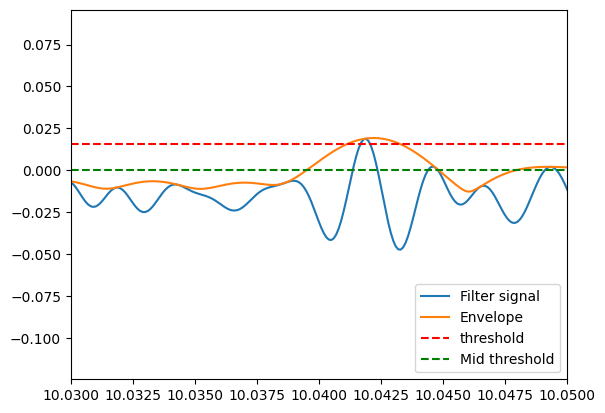

In [59]:
fig = plt.figure()
axs = fig.add_subplot(1,1,1)
axs.plot(t, sigMT, label = 'Filter signal')     # Señal con la extracción del threshold
axs.plot(t,envMT, label = 'Envelope')           # Envoltura menos el thold 
axs.axhline(y = thold-medT, color='r',linestyle='--', label='threshold')         # thold pasa a ser 0
axs.axhline(y = 0, color='g',linestyle='--', label='Mid threshold')    # medT-thold 
plt.legend(loc='lower right')
axs.set_xlim([10.03,10.05])

In [54]:
## Determinar cruce anterior pre y post 
## Pre 

for i in range(pre.shape[0]):
    for i in range(pre[i],0,-1):
        


3129
4628
12472
18549
20952
21015
6


In [84]:
ls = [-5.8, -5 ,-4.2 ,1 ,2.5,3]
ls = np.array(ls)
for i in range(ls.size-1,0,-1):
    print(i, np.sign(ls[i]) - np.sign(ls[i-1]))



5 0.0
4 0.0
3 2.0
2 0.0
1 0.0


(array([], dtype=int64),)

In [ ]:
crossing = np.where(np.diff(np.sign(signal)))[0] 

In [ ]:
def newton_raphson(signal, t, index, max_iter=10, tol=1e-6):
    x_n = t[index]  # Punto inicial
    for _ in range(max_iter):
        # Aproximación de la derivada usando diferencias finitas
        dx = t[1] - t[0]
        f_n = np.interp(x_n, t, signal)  # Interpolación del valor de la señal en x_n
        f_prime_n = (np.interp(x_n + dx, t, signal) - np.interp(x_n - dx, t, signal)) / (2 * dx)  # Derivada central
        
        # Aplicar la fórmula de Newton-Raphson
        if f_prime_n == 0:  # Evitar división por cero
            break
        x_n1 = x_n - f_n / f_prime_n
        
        # Comprobar la convergencia
        if abs(x_n1 - x_n) < tol:
            return x_n1
        
        x_n = x_n1
        
    return x_n  # Devolver el valor refinado

# Refinar los cruces por cero encontrados
refined_crossings = [newton_raphson(signal, t, idx) for idx in crossings]

# Imprimir los momentos refinados de cruce por cero
print(refined_crossings)

In [ ]:
t = timevec[indSW[numInd,0]:indSW[numInd,1]]
print(t[1])
print(t[0])


In [ ]:
t[3129]